<a href="https://colab.research.google.com/github/yasuhiroinoue/AppMathSci/blob/main/%E5%BF%9C%E7%94%A8%E6%95%B0%E7%90%86(2021_11_29).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**応用数理科学（第8回）**##
今回から数回にわたり、時系列解析を学んでいこう。
自己回帰型モデル、状態推定モデルのいくつか有名なモデルを解説する。

###**時系列データ**###
ある時間間隔で測定したデータで、毎時気温、風速から株価指数まで、多種多様にある。また、似たデータ系列として、web広告のクリックのようなイベント記録があるが、これは点過程データと呼び、前者の時系列データとは区別される。

###**構成要素**###
時系列データは、時系列データを構成する３つの要素に分けて特徴づけられる


1.   傾向変動：時間とともに増加（減少）する変動であるが、増加（減少）の傾向を持続するのが特徴
2.   季節変動：１年を周期として規則的に繰り返す変動（海水温やアイスクリームの週次売上など）。１年周期でなくても、周期的なものはここにカテゴライズ。
3.   不規則変動：上記以外の変動成分






###**成分分解モデル(Decomposition model)**###
時系列データを構成要素の合成と考えたとき、その合成には２通りある。


1.   加法モデル(Additive): $x_t =$ Trend + Seasonal + Random
2.   乗法モデル(Multiplicative): $x_t=$ Trend * Seasonal * Random

下記のコードを動かして、成分の合成の仕方の違いで、時系列データの"見た目"にどのような違いが生じるのか実感しよう。

####**加法モデルと乗法モデルのどちらを選ぶか？**####
加法モデルは、$x_t$の値によらず、一定した周期変動の大きさが見られるときに有用。
乗法モデルは、$x_t$の絶対値が大きいときは、大きな変動幅、小さいときは小さな変動幅が見られるときに使える。



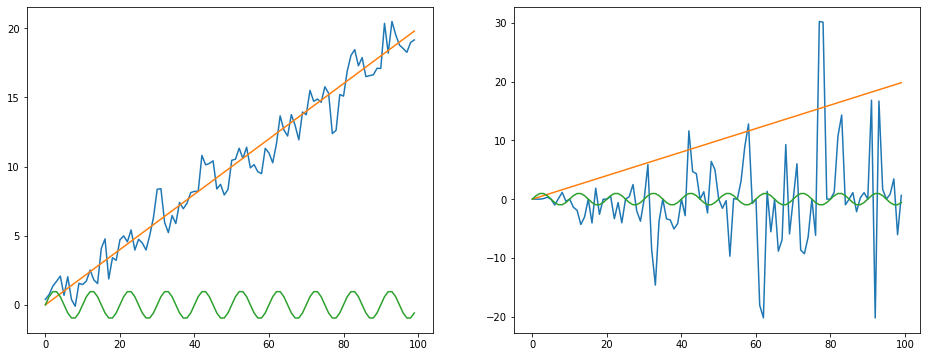

In [ ]:
## 
## ３つの成分の合成の仕方を変えると
## どのような時系列データになるのか実感しよう
##
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt


def f(x):
  return 0.2*x

def season(x):
  return 1.0*np.sin(0.2*np.pi*x)

x=np.zeros(100)
x_trend=np.zeros(100)
x_season=np.zeros(100)
x_random=np.zeros(100)
for i in range (100):
  x_trend[i] = f(i)
  x_season[i] = season(i)
  x_random[i] = np.random.normal(0,1,1)

x = x_trend + x_season + x_random
z = x_trend*x_season*x_random

fig = plt.figure(figsize=(16,6))
ax1 = fig.add_subplot(1,2,1)
ax1.plot(x)
ax1.plot(x_trend)
ax1.plot(x_season)

ax2 = fig.add_subplot(1,2,2)
ax2.plot(z)
ax2.plot(x_trend)
ax2.plot(x_season)

###**平滑化**###
平滑化は、時系列データから不規則変動を除去して、傾向変動や季節変動を取り出すことを目的に行われる。平滑化手法としては、時系列の時間局所（あるタイムウインドウ）における平均値、あるいは、中央値を計算する方法があり、前者を移動平均、後者を移動中央値という。本講義では移動平均を扱う。

$$
T_n = \frac{1}{2k+1}\sum_{i=-k}^k x_{n+j}
$$
もとの時系列が直線とホワイトノイズの和で表されるとき、
$w_n \sim N(0,\sigma^2)$として、
$$
x_n = t_n+w_n\\
t_n = a + bn
$$
$$
T_n = t_n + \frac{1}{2k+1}\sum_{j=-k}^kw_{n+j}
$$
$$
E\left[\sum_{j=-k}^kw_{n+j}\right] = 0
$$

$$
E\left[\left(\sum_{j=-k}^kw_{n+j}\right)^2\right] = (2k+1)\sigma^2
$$
$$
Var\left[\frac{1}{2k+1}\sum_{j=-k}^kw_{n+j}\right]=\frac{\sigma^2}{2k+1}
$$
よって、移動平均の期待値$T_n=t_n$、分散は元の時系列$x_n$の$1/(2k+1)$倍に減少する。

下記のコードを実行し、移動平均のタイムウインドウを様々に試すことで、時系列データのもつ傾向がどのように見えるのかを実感しよう。



     Month  #Passengers
0  1949-01          112
1  1949-02          118
2  1949-03          132
3  1949-04          129
4  1949-05          121


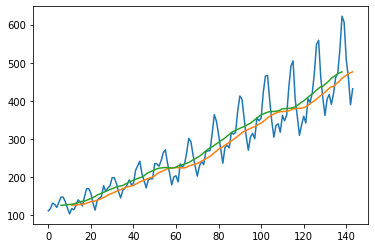

In [ ]:
## 移動平均の例
## 講義用にデータを下記からダウンロードし、colabのフォルダに入れてください
## https://www.dropbox.com/s/pld64byqj7nevhu/AirPassengers.csv?dl=0
##
## これは航空機乗客データです
## Rで有名なデータ (https://stat.ethz.ch/R-manual/R-devel/library/datasets/html/AirPassengers.html)
##
import pandas as pd

timeWindow=12 #12months

df = pd.read_csv("AirPassengers.csv")
print(df.head())
passengers = df['#Passengers']
passengers.plot()
## 12か月移動平均
## 後方移動平均(対象時点とそれより過去のデータを使って平均)
passengers.rolling(window=timeWindow,center=False).mean().plot()
## 中央移動平均（対象時点が中心となるよう、過去・未来のデータを使って平均）
passengers.rolling(window=timeWindow,center=True).mean().plot()


###**共分散関数と自己相関関数**###
データが得られたときに、一番最初に行うのが、基本的な統計量を用いた要約である。

自己共分散関数は、時系列の過去の変動との関連の強さを表現、相互共分散関数は他の時系列の変動との関連の強さを表現する。１変量（１次元）時系列の場合は、自己相関、自己共分散が基本的な統計量である。多変量の場合は、平均ベクトル、相互相関、相互共分散が基本となる。

時系列$y_n$と時間$k$だけシフトした時系列$y_{n-k}$との共分散
$$
Cov(y_n, y_{n-k}) = E[(y_n-\mu_n)(y_{n-k}-\mu_{n-k})]
$$
を時系列$y_n$の自己共分散という。$k$を**ラグ**という。$k=0$のとき、分散関数$Var(y_n)$となる。

平均、分散、共分散が時間のシフトに対して、不変であるとき、**弱定常**という。
$$
E[y_n] = E[y_{n-l}]\\
Var(y_n) = Var(y_{n-l})\\
Cov(y_n,y_m)=Cov(y_{n-l},y_{m-l})
$$
'弱'があれば、'強'は何かということであるが、時系列の確率分布が時間シフトに対して不変のときに、その時系列を強定常という。
すなわち、時刻$i_1 < i_2 < \cdots < i_k$について、時系列$y_{i_1}, y_{i_2},\cdots,y_{i_k}$の同時確率密度関数$f(y_{i_1},\cdots,y_{i_k})$について、
$$
f(y_{i_1},\cdots,y_{i_k}) = f(y_{i_1-l},\cdots,y_{i_k-l})
$$
が成り立つことである。
もし、同時確率密度関数がガウス型（ガウス型時系列という）であれば、１次モーメント、２次モーメントまでで正規分布の形が決まるので、弱定常性と強定常性は同じになる。

####**定常時系列**####
定常性を仮定すると、平均値関数$\mu_n$は時刻$n$に依存せず
$$
\mu = E[y_n]
$$
また、共分散は時間差$k$のみに依存するので
$$
C_k = Cov(y_n,y_{n-k})=E[(y_n-\mu)(y_{n-k}-\mu)]
$$
と表される。これを定常時系列の自己共分散関数という。

$y_n$と$y_{n-k}$の相関係数
$$
R_k = \frac{Cov(y_n,y_{n-k})}{\sqrt{Var(y_n)Var(y_{n-k})}}
$$
をラグ$k$の関数とみなしたものを、自己相関関数という。定常時系列では、
$Var(y_n)=Var(y_{n-k})=C_0$より、
$$
R_k = C_k/C_0
$$
となる。

多変量のときには、対応する関数は以下の通り。多変量時系列$y_n$を
$$
y_n = (y_n(1),\cdots,y_n(l))^T
$$
とし、
$$
C_k(i,j) = Cov(y_n(i),y_{n-k}(j))=E[(y_n(i)-\mu(i))(y_{n-k}(j)-\mu(j))^T]
$$
$C_k$は$l\times l$行列となり、ラグ$k$の共分散関数という。
対角成分$C_k(i,i)$は$i$番目の時系列$y_n(i)$の自己共分散関数となっている。
$y_n(i)$と$y_{n-k}(j)$の相関係数を
$$
R_k(i,j) = \frac{C_k(i,j)}{\sqrt{C_0(i,i)C_0(j,j)}}
$$
と表し、$l \times l$行列$R_k$を相互相関関数という。

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


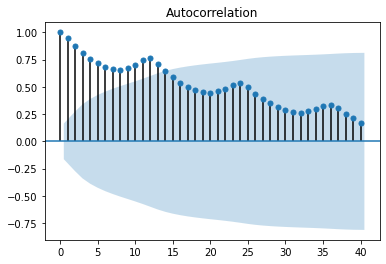

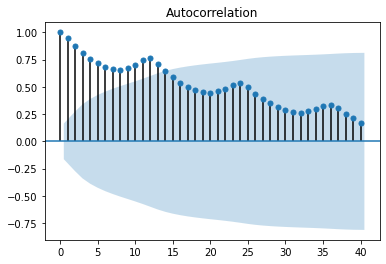

In [ ]:
import pandas as pd
import statsmodels.api as sm

timeWindow=12 #12months

df = pd.read_csv("AirPassengers.csv")
passengers = df['#Passengers']

#自己相関
p_acf = sm.tsa.stattools.acf(passengers)

##自己相関係数のプロットをコレログラムという
##帯の外にある点は有意水準5％で無相関という帰無仮説を棄却する
sm.graphics.tsa.plot_acf(passengers,lags=40)

##**自己回帰型モデル**##
###**ARMAモデル**###
時系列$y_n$を過去の観測値$y_{n-i}$の線形和とホワイトノイズの現在および過去の値の線形和で表したモデルを**自己回帰移動平均モデル(Auto Regration Moving Average model**という。(頭文字をとって、ARMAモデル)

$$
y_n = \sum_{i=1}^m a_iy_{n-i} + v_n - \sum_{i=1}^lb_iv_{n-i}\\
v_n\sim N(0,\sigma^2)
$$
ここで、$m, a_i$をそれぞれ自己回帰の次数、自己回帰係数という。また、$l,b_i$を移動平均の次数、移動平均係数という。2つの次数をまとめて、$(m,l)$次のARMAモデルという。
ARMAモデルに従う時系列は、ARMA過程あるいはARMA$(m,l)$過程と呼ばれる。

$l=0$と仮定すると、$m$次の自己回帰モデル(ARモデル)となる。
$$
y_n = \sum_{i=1}^m a_iy_{n-i} + v_n 
$$
$m=0$と仮定すると、$l$次の移動平均モデル(MAモデル)となる。
$$
y_n = v_n - \sum_{i=1}^lb_iv_{n-i}
$$

###**インパルス応答関数と自己共分散関数**###
時間シフトオペレーター$B$を
$$
By_n = y_{n-1}
$$
と定義する。
ARMAモデルは
$$
(1-\sum_{i=1}^ma_iB^i)y_n = (1-\sum_{i=1}^lb_iB^i)v_n
$$
と表される。
いま、$a(B):=1-\sum_{i=1}^ma_iB^i$、$b(B):=1-\sum_{i=1}^lb_iB^i$と定義し
$$
a(B)y_n = b(B)v_n
$$
また、
$$
a(B)^{-1}b(B)=\sum_{i=0}^\infty g_iB^i
$$
と書くことにすると
$$
y_n = g(B)v_n = \sum_{i=0}^\infty g_i v_{n-i}
$$
これはARMA過程を無限次MAモデルで表現できることを示している。
$g(B)$をARMAモデルのインパルス応答関数という。
$$
g_0=1\\
g_i=\sum_{j=1}^ia_jg_{i-j}-b_i (i=1,2,\cdots)
$$
ただし、モデル次数より大きい添え字の係数値はゼロとする。
$a_j=0 ( j>m), b_i=0 (i > l)$

ARMAモデル式の両辺に$y_{n-k}$をかけて期待値を取る
$$
E[y_n y_{n-k}]= \sum_{i=1}^m a_iE[y_{n-i}y_{n-k}] + E[v_n y_{n-k}] - \sum_{i=1}^lb_iE[v_{n-i}y_{n-k}]
$$
ここで、右辺第2項、第3項を拙速に期待値ゼロにしていはいけない。インパルス応答関数を用いると

$$
E[v_{n-i} y_{n-k}]=\sum_{j=0}^\infty g_j E[v_{n-i} v_{n-k-j}]\\
$$
$$
=
\begin{array}
 00 & (i > k)\\
\sigma^2 g_{i-k} & (i \leq k)
\end{array}
$$
となる。
よって、自己共分散関数は
$$
C_0 = \sum_{i=1}^ma_iC_{-i}+\sigma^2(1-\sum_{i=1}^lb_ig_i)\\
C_k  = \sum_{i=1}^m a_iC_{k-i}-\sigma^2\sum_{i=1}^lb_ig_{i-k}, (k=1,2,\cdots)
$$

**Yule-Waker方程式**

特に、$l=0$としたときにはARモデルの場合の関係式として、以下のYule-Waker（ユール・ウォーカー）方程式が得られる。
$$
C_0 = \sum_{i=1}^ma_iC_{-i}+\sigma^2\\
C_k  = \sum_{i=1}^m a_iC_{k-i}, (k=1,2,\cdots)
$$
時系列から標本自己共分散関数$\hat C_k$を計算し、Yule-Waker方程式を解くと、ARモデルにおける自己回帰係数の推定値$\hat a_i$が得られる。
また、$C_0$の式より、分散の推定値$\hat\sigma^2$も得られる。これらを、Yule-Walker推定値という。これでAICの計算を行うことが出来るので、ARモデルの次数$m$を決めることが出来る。

##**解析実習 part1**##
太陽黒点の数の時系列解析をARMAモデルで行ってみよう。
まず、Yearly mean total sunspot number (メニューTotal sunspot number --> Yearly mean total sunspot numberを選択)のデータを[ダウンロード](https://wwwbis.sidc.be/silso/datafiles)し、Colabのフォルダにアップロードしよう。


Pythonの[statsmodels](https://www.statsmodels.org/stable/index.html)を利用し、まず、(3,0)次ARMAモデルによる解析を行う。モデルの次数選択については、あまり宜しくない例となっている。

その次に、適切な次数選択をpart2で体験しよう。情報量基準を用いたモデル選択により、どのように改善されるのかを、残差の相関関数に注目しながら確かめよう。

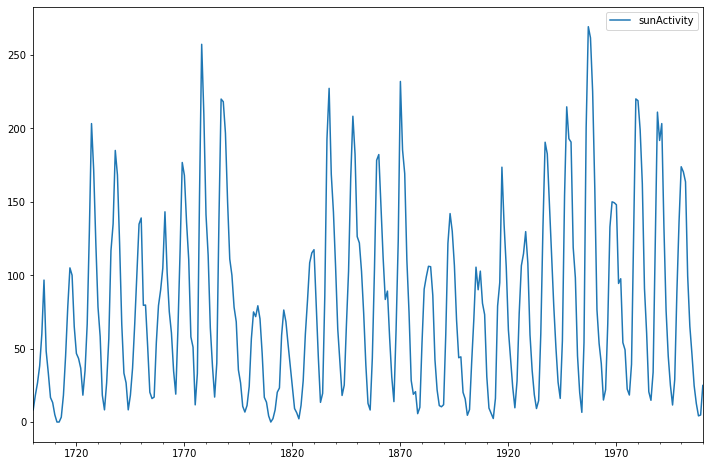

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats

## ARIMAモデルを読み込む
## ARMA(p,q) = ARIMA(p,0,q)
## ARIMA(p,d,q)の次数dは、d階差分を表す。
## 差分を取ると定常過程になるものを和分過程という
## トレンドがある場合に有効
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.api import qqplot

## Yearly mean total sunspot number
## ダウンロード：https://wwwbis.sidc.be/silso/datafiles
## データの並びの説明: https://wwwbis.sidc.be/silso/infosnytot
## 上記サイトから年平均データのcsvをダウンロードしよう。
## ダウンロードしたらcolabのフォルダにアップロードしよう。ドラッグ＆ドロップでできる。
##
df = pd.read_csv("SN_y_tot_V2.0.csv", sep=";", names=('year', 'sunActivity', 'sd', 'numObs','defMarker'))
dtaFull=df[['year','sunActivity']]

## 2021.10月時点でのデータに対するインデックスの割り付けをしているので、最終行が2020年以降であったら
## pd.Index(sm.tsa.datetools.dates_from_range("1700", "2020"))の2020を最終行の西暦年にすること。
dtaFull.index = pd.Index(sm.tsa.datetools.dates_from_range("1700", "2020"))
dtaFull.index.freq = dtaFull.index.inferred_freq
del dtaFull["year"]

##直近10年分を除いたデータをモデルフィットに使用し、直近10年を予測する
dta = dtaFull[:len(dtaFull)-10]
dta.plot(figsize=(12, 8))


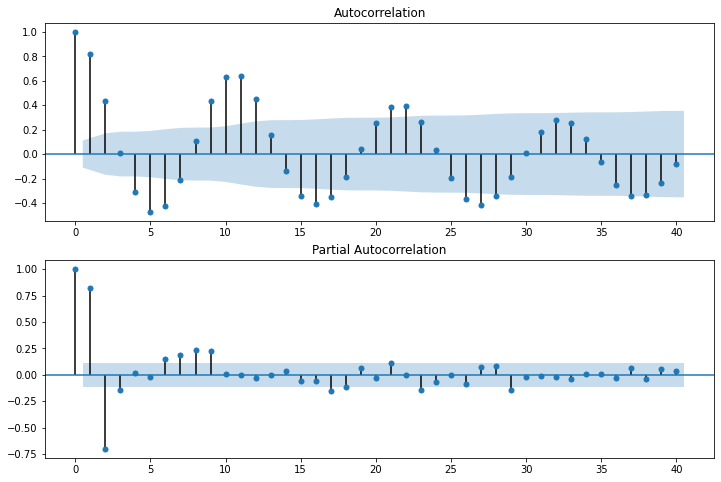

In [ ]:
## 自己相関からおよそ11年周期だと分かる
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(dta.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(dta, lags=40, ax=ax2)

In [ ]:
arma_mod20 = ARIMA(dta, order=(2, 0, 0)).fit()
print(arma_mod20.params)
print(arma_mod20.aic, arma_mod20.bic, arma_mod20.hqic)

const                79.437116
ar.L1.sunActivity     1.386040
ar.L2.sunActivity    -0.694645
dtype: float64
2913.490401836748 2928.449573485465 2919.4697868900525


In [ ]:
arma_mod30 = ARIMA(dta, order=(3, 0, 0)).fit()
print(arma_mod30.params)
print(arma_mod30.aic, arma_mod30.bic, arma_mod30.hqic)

const                79.575542
ar.L1.sunActivity     1.286871
ar.L2.sunActivity    -0.497627
ar.L3.sunActivity    -0.142077
dtype: float64
2909.1572159172483 2927.8561804781443 2916.631447233879


In [ ]:
## The Durbin-Watson statistic
## 
sm.stats.durbin_watson(arma_mod30.resid.values)

1.9657946715753243

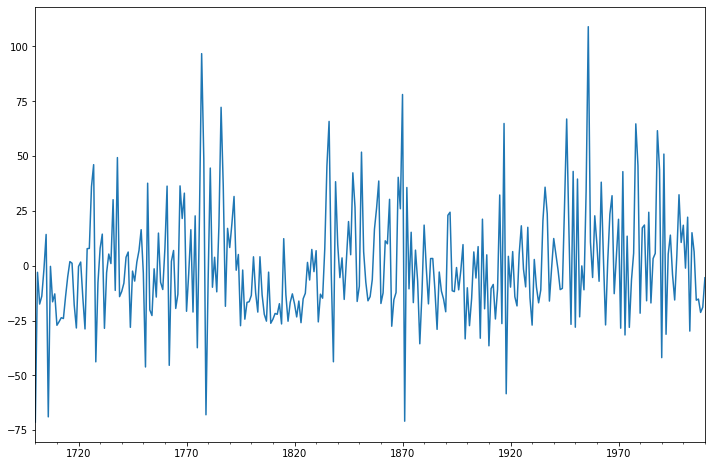

In [ ]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
ax = arma_mod30.resid.plot(ax=ax)

In [ ]:
##残差が正規分布からズレていないかを確認
resid = arma_mod30.resid
stats.normaltest(resid)

NormaltestResult(statistic=36.79170293499885, pvalue=1.0251400900315372e-08)

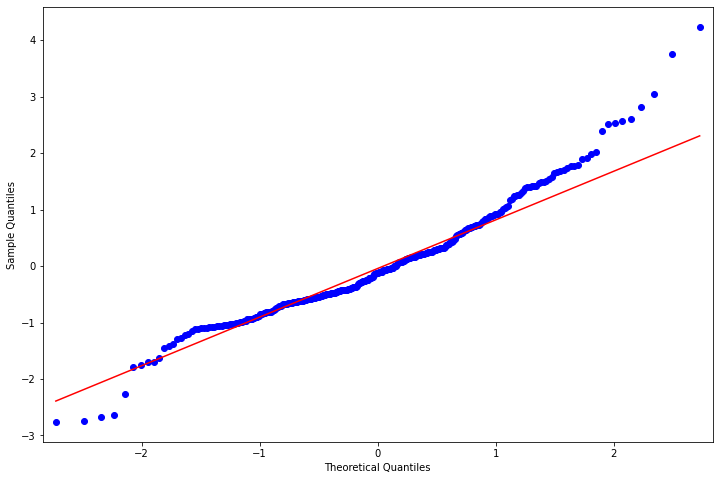

In [ ]:
##Q-Qプロットでも確認
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
fig = qqplot(resid, line="q", ax=ax, fit=True)

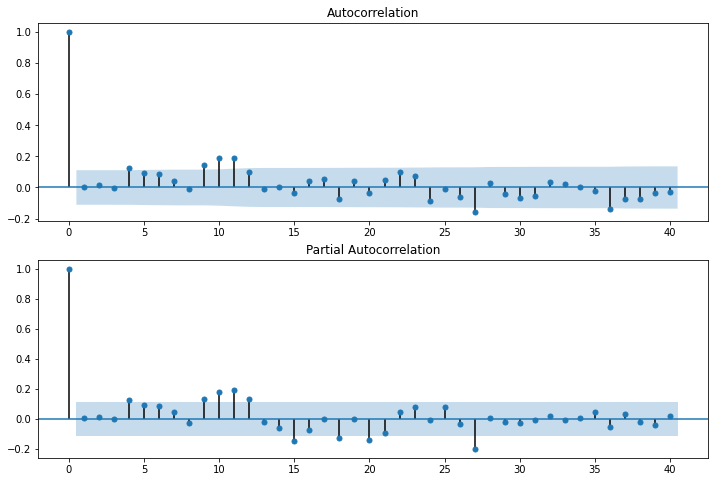

In [ ]:
##
## 残差の自己相関、偏自己相関がともに残っているので、時系列を捉えきれていないモデルであることを示唆している
## （残差はホワイトノイズに従うべき）
##
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(resid.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(resid, lags=40, ax=ax2)

In [ ]:
r,q,p = sm.tsa.acf(resid, fft=True, qstat=True)
data = np.c_[r[1:], q, p]
index = pd.Index(range(1,q.shape[0]+1), name="lag")
##
## AutoCorrelation, Q-value, P-value
##
table = pd.DataFrame(data, columns=["AC", "Q", "Prob(>Q)"], index=index)
print(table)

           AC          Q  Prob(>Q)
lag                               
1    0.004736   0.007043  0.933119
2    0.015191   0.079738  0.960915
3   -0.002426   0.081599  0.993950
4    0.126891   5.187007  0.268642
5    0.092118   7.886433  0.162607
6    0.085310  10.209177  0.116115
7    0.041610  10.763579  0.149269
8   -0.008176  10.785057  0.214178
9    0.146904  17.741148  0.038298
10   0.191654  29.620028  0.000988
11   0.189217  41.237312  0.000022
12   0.101163  44.569113  0.000012
13  -0.011928  44.615588  0.000024
14   0.000757  44.615776  0.000047
15  -0.034359  45.004018  0.000076
16   0.043131  45.617868  0.000112
17   0.052197  46.519950  0.000144
18  -0.072606  48.271342  0.000137
19   0.040807  48.826469  0.000195
20  -0.038414  49.320091  0.000277
21   0.046003  50.030441  0.000361
22   0.099924  53.393590  0.000200
23   0.072817  55.185736  0.000184
24  -0.089157  57.881846  0.000126
25  -0.012219  57.932665  0.000200
26  -0.058706  59.109777  0.000221
27  -0.154995  67.34

In [ ]:
predict_sunspots = arma_mod30.predict("2010", "2022", dynamic=True)
print(predict_sunspots)

2010-12-31     30.373712
2011-12-31     64.178653
2012-12-31     94.869821
2013-12-31    113.909684
2014-12-31    118.335847
2015-12-31    110.196471
2016-12-31     94.814432
2017-12-31     78.441252
2018-12-31     66.182028
2019-12-31     60.739171
2020-12-31     62.161700
2021-12-31     68.442585
2022-12-31     76.590689
Freq: A-DEC, dtype: float64


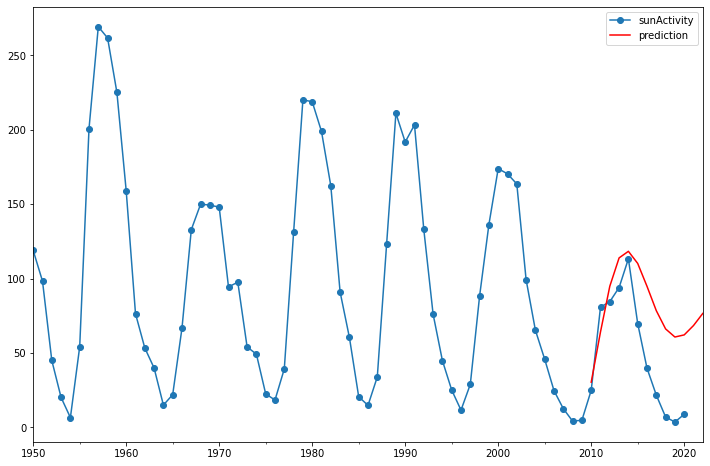

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
dtaFull.loc['1950':].plot(ax=ax,marker="o")
predict_sunspots.plot(ax=ax, style='r', label="prediction")
plt.legend()

##**解析実習 part2**##
次数を決め打ちせず、次数の組み合わせの中で、AIC、BICが最小となるモデル選択を行う

In [ ]:
##
## AIC, BIC によるモデル選択
##
from statsmodels.tsa import stattools
res = stattools.arma_order_select_ic(dta, max_ar=13, max_ma=6, ic=["aic","bic"])



/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/pyt

In [ ]:
print("AIC_Minimum model:ARMA",res.aic_min_order, "BIC_Minimum model:ARMA",res.bic_min_order)

AIC_Minimum model:ARMA (6, 4) BIC_Minimum model:ARMA (4, 2)


####**AICをもとにモデル選択**####

In [ ]:
print(res.aic)

              0            1  ...            5            6
0   3457.825005  3177.095851  ...  2942.304864  2944.043160
1   3116.161048  3007.630113  ...  2948.778345  2939.975770
2   2913.490402  2909.718829  ...  2893.808085  2890.029488
3   2909.157216  2910.875184  ...  2873.197503  2875.174750
4   2911.043903  2900.377430  ...  2875.181601  2873.835054
5   2912.896820  2898.133572  ...  2865.008881  2875.819190
6   2909.002453  2884.160004  ...  2866.990583  2866.825209
7   2897.842978  2878.654410  ...  2878.517084  2864.404478
8   2885.463218  2876.601062  ...  2870.917350  2865.367803
9   2872.612077  2874.454420  ...  2864.583329  2867.363017
10  2874.458728  2871.386673  ...  2871.274177          NaN
11  2876.452082  2872.591519  ...  2870.974999          NaN
12  2878.440308  2874.244241  ...  2872.016439          NaN
13  2880.387077  2876.076650  ...  2891.484721  2882.673288

[14 rows x 7 columns]


In [ ]:
arma_mod64 = ARIMA(dta, order=(6, 0, 4)).fit()
print(arma_mod64.params)
print(arma_mod64.aic,arma_mod64.bic)

const                80.515068
ar.L1.sunActivity     3.803474
ar.L2.sunActivity    -6.873490
ar.L3.sunActivity     7.379365
ar.L4.sunActivity    -4.885270
ar.L5.sunActivity     1.831582
ar.L6.sunActivity    -0.274917
ma.L1.sunActivity    -2.663446
ma.L2.sunActivity     3.407918
ma.L3.sunActivity    -2.349627
ma.L4.sunActivity     0.728394
dtype: float64
2862.9041825217723 2907.781697467923


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [ ]:
sm.stats.durbin_watson(arma_mod64.resid.values)

1.9938059846167817

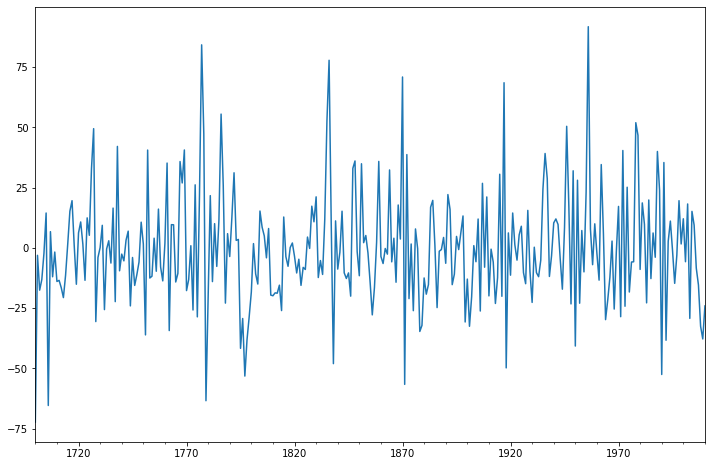

In [ ]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
ax = arma_mod64.resid.plot(ax=ax)

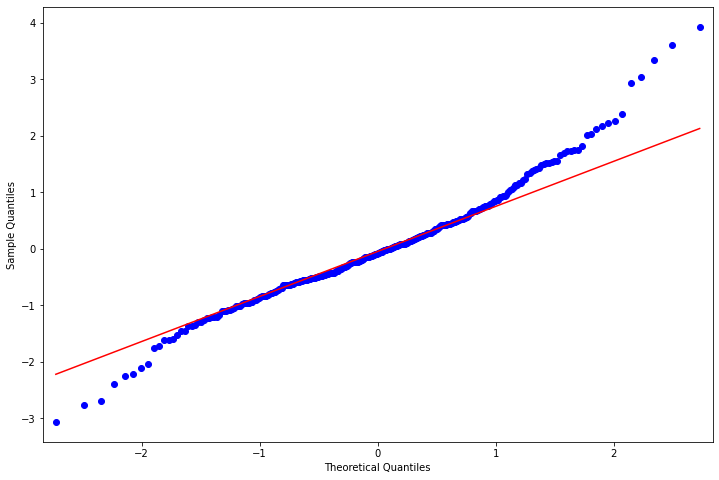

In [ ]:
resid = arma_mod64.resid
stats.normaltest(resid)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
fig = qqplot(resid, line="q", ax=ax, fit=True)

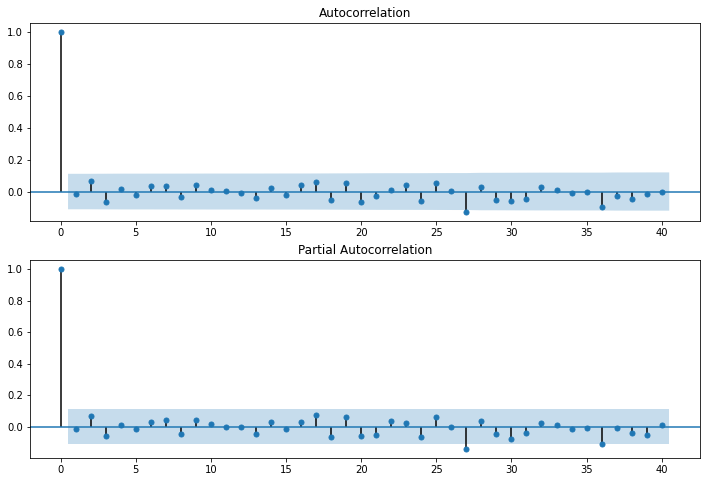

In [ ]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(resid.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(resid, lags=40, ax=ax2)

In [ ]:
r,q,p = sm.tsa.acf(resid, fft=True, qstat=True)
data = np.c_[r[1:], q, p]
index = pd.Index(range(1,q.shape[0]+1), name="lag")
##
## AutoCorrelation, Q-value, P-value
##
table = pd.DataFrame(data, columns=["AC", "Q", "Prob(>Q)"], index=index)
print(table)

           AC          Q  Prob(>Q)
lag                               
1   -0.013987   0.061434  0.804244
2    0.064546   1.373885  0.503112
3   -0.063746   2.658178  0.447381
4    0.016223   2.741625  0.601951
5   -0.022892   2.908328  0.714116
6    0.031974   3.234604  0.778878
7    0.033409   3.591999  0.825387
8   -0.037114   4.034517  0.853996
9    0.041440   4.588041  0.868641
10   0.006538   4.601863  0.916140
11   0.005794   4.612755  0.948462
12  -0.009935   4.644889  0.968801
13  -0.037837   5.112551  0.972631
14   0.022195   5.274002  0.981622
15  -0.018978   5.392452  0.988250
16   0.041488   5.960424  0.988517
17   0.060823   7.185314  0.981020
18  -0.054565   8.174475  0.975925
19   0.056054   9.221936  0.969609
20  -0.067137  10.729716  0.952933
21  -0.028765  11.007447  0.962642
22   0.009760  11.039535  0.974180
23   0.039527  11.567625  0.976614
24  -0.061162  12.836412  0.968741
25   0.051977  13.755925  0.965822
26   0.003876  13.761058  0.976016
27  -0.125717  19.17

In [ ]:
predict_sunspots = arma_mod64.predict("2011", "2022", dynamic=True)
print(predict_sunspots)

2011-12-31     65.975409
2012-12-31     95.520176
2013-12-31    104.972824
2014-12-31     99.564898
2015-12-31     85.570618
2016-12-31     64.642580
2017-12-31     37.968396
2018-12-31     12.703703
2019-12-31      1.381270
2020-12-31     13.228927
2021-12-31     45.504859
2022-12-31     83.600779
Freq: A-DEC, dtype: float64


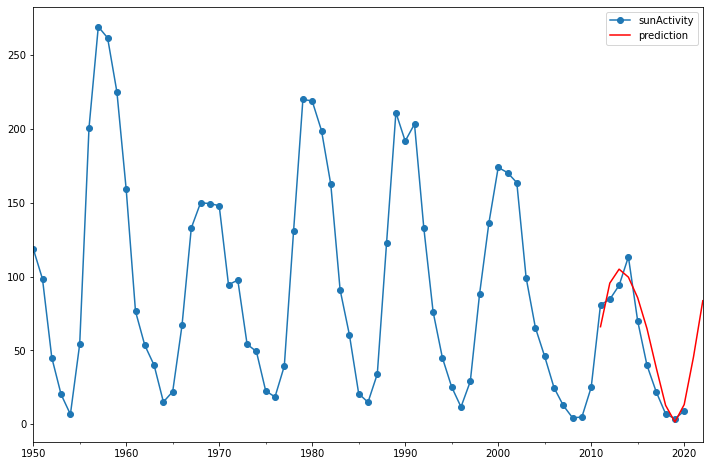

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
dtaFull.loc['1950':].plot(ax=ax,marker="o")
predict_sunspots.plot(ax=ax, style='r', label="prediction")
plt.legend()

####**BICをもとにモデル選択**####

In [ ]:
print(res.bic)

              0            1  ...            5            6
0   3465.304591  3188.315230  ...  2968.483414  2973.961503
1   3127.380427  3022.589284  ...  2978.696688  2973.633906
2   2928.449573  2928.417793  ...  2927.466221  2927.427417
3   2927.856180  2933.313941  ...  2910.595432  2916.312472
4   2933.482660  2926.555981  ...  2916.319323  2918.712569
5   2939.075371  2928.051915  ...  2909.886396  2924.436498
6   2938.920797  2917.818141  ...  2915.607891  2919.182309
7   2931.501114  2916.052339  ...  2930.874184  2920.501372
8   2922.861148  2917.738784  ...  2927.014243  2925.204490
9   2913.749799  2919.331935  ...  2924.420016  2930.939496
10  2919.336243  2920.003981  ...  2934.850656          NaN
11  2925.069390  2924.948620  ...  2938.291272          NaN
12  2930.797409  2930.341135  ...  2943.072504          NaN
13  2936.483970  2935.913336  ...  2966.280579  2961.208939

[14 rows x 7 columns]


In [ ]:
arma_mod42 = ARIMA(dta, order=(4, 0, 2)).fit()
print(arma_mod42.params)
print(arma_mod42.aic, arma_mod42.bic)

const                77.800668
ar.L1.sunActivity     2.797929
ar.L2.sunActivity    -3.096153
ar.L3.sunActivity     1.511152
ar.L4.sunActivity    -0.237393
ma.L1.sunActivity    -1.644322
ma.L2.sunActivity     0.786745
dtype: float64
2874.228079669575 2904.1464229670087


In [ ]:
sm.stats.durbin_watson(arma_mod42.resid.values)

1.955276230102299

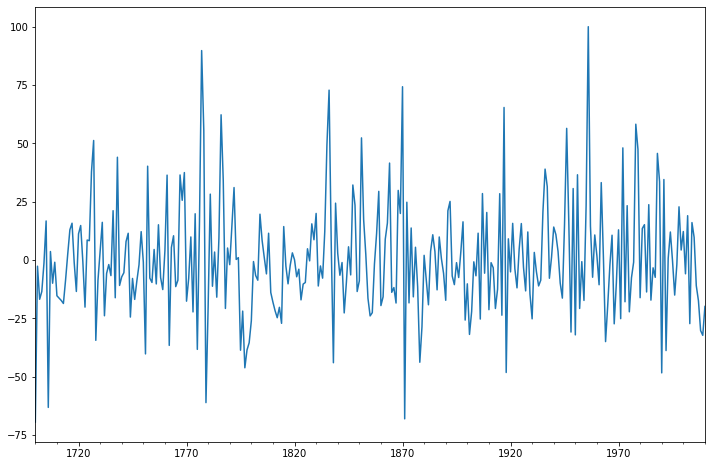

In [ ]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
ax = arma_mod42.resid.plot(ax=ax)

In [ ]:
resid = arma_mod42.resid
stats.normaltest(resid)

NormaltestResult(statistic=32.48742690350116, pvalue=8.819518636790817e-08)

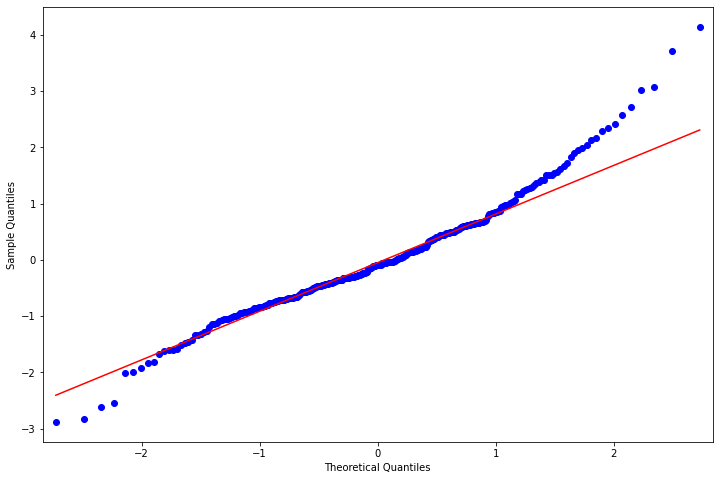

In [ ]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
fig = qqplot(resid, line="q", ax=ax, fit=True)

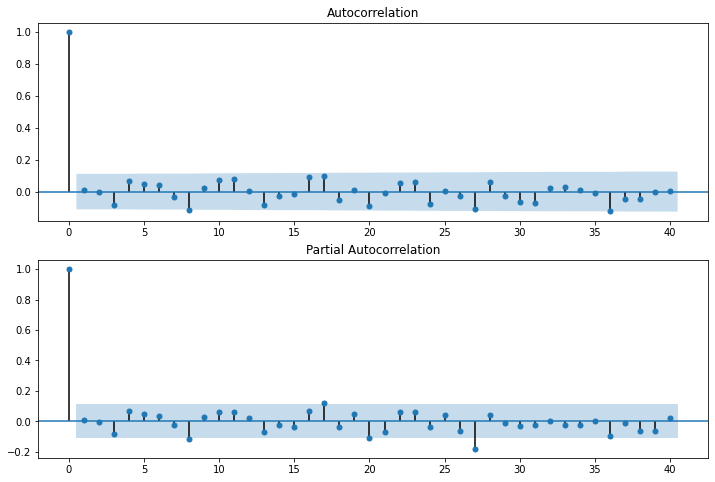

In [ ]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(resid.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(resid, lags=40, ax=ax2)

In [ ]:
r,q,p = sm.tsa.acf(resid, fft=True, qstat=True)
data = np.c_[r[1:], q, p]
index = pd.Index(range(1,q.shape[0]+1), name="lag")
##
## AutoCorrelation, Q-value, P-value
##
table = pd.DataFrame(data, columns=["AC", "Q", "Prob(>Q)"], index=index)
print(table)

           AC          Q  Prob(>Q)
lag                               
1    0.007894   0.019566  0.888755
2   -0.003216   0.022824  0.988653
3   -0.083370   2.219532  0.528111
4    0.064710   3.547270  0.470727
5    0.048992   4.310821  0.505587
6    0.038998   4.796202  0.570205
7   -0.034639   5.180414  0.637957
8   -0.113225   9.298983  0.317705
9    0.025272   9.504841  0.392035
10   0.069494  11.066674  0.352347
11   0.077268  13.003897  0.293071
12   0.004017  13.009149  0.368376
13  -0.081270  15.166626  0.297067
14  -0.027496  15.414423  0.350425
15  -0.013621  15.475436  0.417743
16   0.089851  18.139404  0.315797
17   0.099249  21.400824  0.208873
18  -0.055167  22.411925  0.214209
19   0.012235  22.461828  0.261878
20  -0.088637  25.089949  0.198012
21  -0.008614  25.114853  0.242224
22   0.054846  26.128046  0.246225
23   0.058066  27.267658  0.244746
24  -0.080612  29.471735  0.202881
25   0.003783  29.476606  0.244485
26  -0.025466  29.698118  0.280306
27  -0.107120  33.63

In [ ]:
predict_sunspots = arma_mod42.predict("2010", "2022", dynamic=True)
predict_sunspots_onestep = arma_mod42.predict("1950", "2022", dynamic=False)
print(predict_sunspots)

2010-12-31     44.833150
2011-12-31     90.409736
2012-12-31    122.309661
2013-12-31    130.805012
2014-12-31    115.176872
2015-12-31     82.533589
2016-12-31     44.852052
2017-12-31     14.857169
2018-12-31      1.982499
2019-12-31      9.635622
2020-12-31     34.528996
2021-12-31     68.148651
2022-12-31     99.761746
Freq: A-DEC, dtype: float64


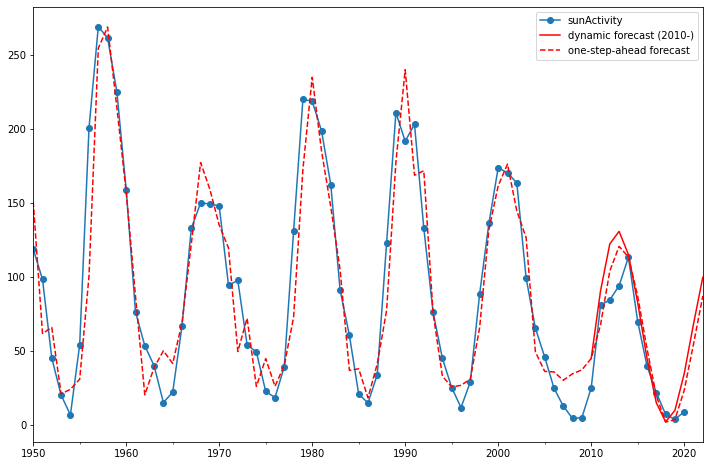

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
dtaFull.loc['1950':].plot(ax=ax,marker="o")
predict_sunspots.plot(ax=ax, style='r', label="dynamic forecast (2010-)")
predict_sunspots_onestep.plot(ax=ax, style='r--', label="one-step-ahead forecast")
plt.legend()